# Variational Autoencoders (VAEs) for CryptoPunks Dataset

## Introduction

This Jupyter notebook explores the application of Variational Autoencoders (VAEs) to the CryptoPunks dataset. CryptoPunks are unique digital collectibles on the Ethereum blockchain, consisting of 10,000 algorithmically generated characters with distinct attributes.


In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from datasets import load_dataset

In [8]:
# Training on Macbook Pro with M1 chip, using Metal Performance Shaders
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [9]:
# Load the dataset
dataset = load_dataset("huggingnft/cryptopunks", split="train")

# Define split ratio
train_ratio = 0.8

# Create the train-test split
split_dataset = dataset.train_test_split(test_size=1 - train_ratio)

# Access the train and test splits
train_data = split_dataset['train']
test_data = split_dataset['test']

In [10]:
# Function to convert image to tensor
def transform_func(img):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Transform image to 128x128
        transforms.PILToTensor(),       # Convert PIL Image to PyTorch tensor
    ])
    return transform(img)

# Define class for Cryptopunks dataset
class PunkDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
        self.transform = transform_func

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image = self.data_list[idx]["image"]
        # Convert PIL Image to PyTorch tensor
        if isinstance(image, Image.Image):
            image = self.transform(image)
        return image
    
# Initialize the Punk dataset for training and test sets
train_dataset = PunkDataset(train_data)
test_dataset = PunkDataset(test_data)

In [11]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
# Validate the dataset sizes that they are 80% and 20% of the total dataset
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 8000
Number of test samples: 2000


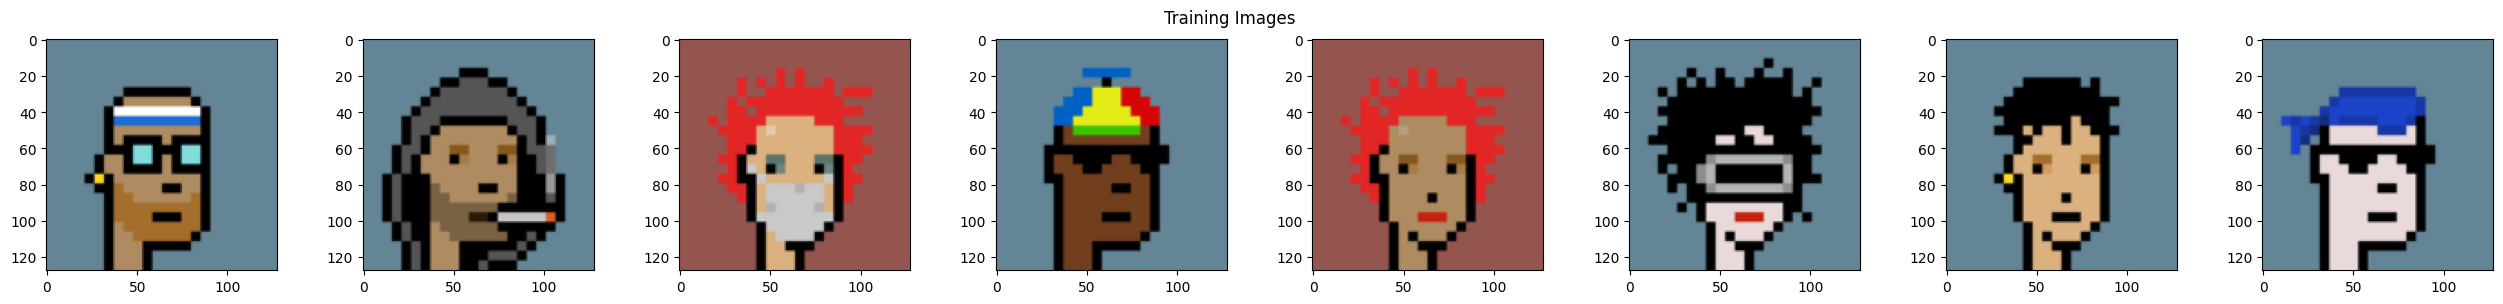

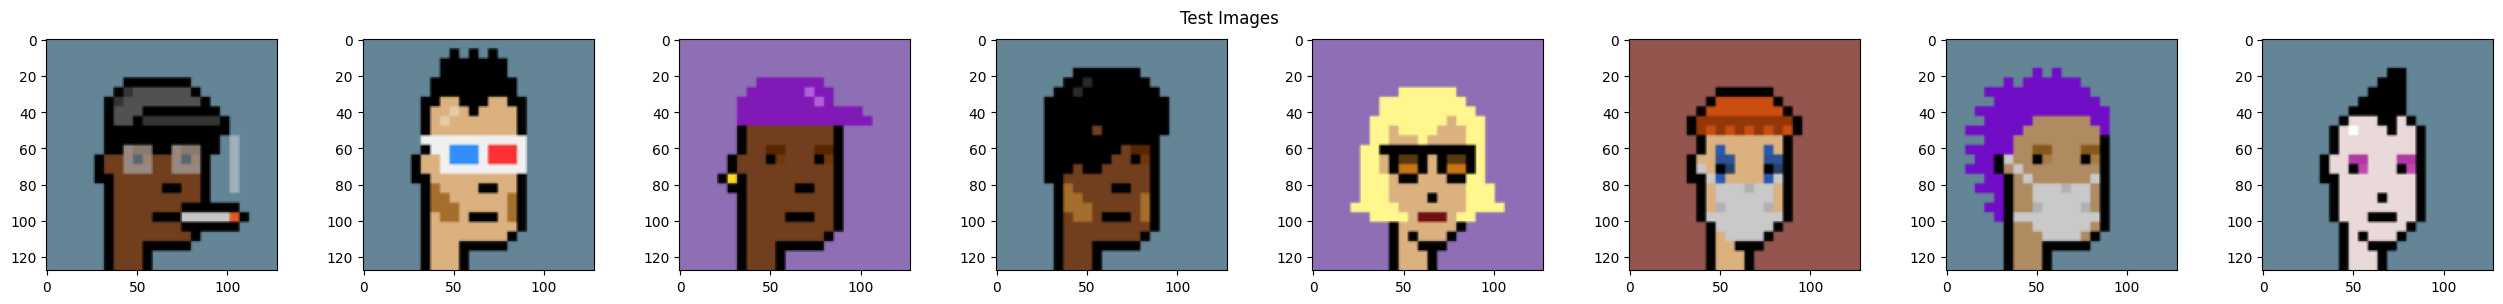

In [13]:
# Display images in a grid
def plot_images_from_loader(data_loader, title, num_images=8):
    """Display a set of images from the DataLoader in a grid."""
    # Get a batch of images
    images = next(iter(data_loader))
    
    # Create a grid from the images
    fig, axes = plt.subplots(1, num_images, figsize=(32, 3))
    fig.suptitle(title)
    
    # Plot each image
    for i in range(num_images):
        ax = axes[i]
        image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to NumPy array
        ax.imshow(image)
    plt.show()

# Display images from training and test loaders
plot_images_from_loader(train_loader, title="Training Images")
plot_images_from_loader(test_loader, title="Test Images")